# Checking the preprocessed data
In this notebook, we'll analyze the preprocessed datasets to check their quality.

# Imports and paths

In [1]:
%cd ..

/home/cdauvill/inria/multi_sources


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import yaml
from hydra import compose, initialize
from omegaconf import OmegaConf
from netCDF4 import Dataset
from pathlib import Path
from multi_sources.data_processing.multi_source_dataset import MultiSourceDataset
from multi_sources.data_processing.utils import read_variables_dict

In [4]:
# context initialization
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="train", overrides=["paths=local"])
paths = cfg['paths']
sources_cfg = cfg['sources']

In [5]:
sources_cfg

{'tc_primed': {'AMSR2_GCOMW1': {'S4': {'variables': ['TB_36.5H']}}, 'ATMS_NPP': {'S2': {'variables': ['TB_31.4QV']}}, 'ATMS_NOAA20': {'S2': {'variables': ['TB_31.4QV']}}, 'GMI_GPM': {'S1': {'variables': ['TB_36.64H']}}, 'SSMIS_F16': {'S2': {'variables': ['TB_37.0H']}}, 'SSMIS_F17': {'S2': {'variables': ['TB_37.0H']}}, 'SSMIS_F18': {'S2': {'variables': ['TB_37.0H']}}}}

# Building the dataset
We'll use the ```MultiSourceDataset```, which is a map-style torch ```Dataset``` custom subclass.

In [6]:
# Create the dataset
dataset_dir = paths['preprocessed_dataset']
split = 'train'
included_vars = read_variables_dict(sources_cfg)
dataset = MultiSourceDataset(dataset_dir, split, included_vars, min_available_sources_prop=0.6)

Browsing requested sources and loading metadata...
Found 7 sources in the dataset.


In [7]:
len(dataset)

1611

# Displaying a single sample
We'll first have a look at a single sample yielded by the dataset.

In [8]:
rng = np.random.default_rng(17)
sample = dataset[rng.integers(low=0, high=len(dataset), size=1)[0]]
sample = dataset[61]
# sample is a dict {source_name: map} where map is a dict containing
# various information about the sample.

In [9]:
for key in sample[list(sample.keys())[0]]:
    print(key)

source_type
avail
dt
context
coords
landmask
dist_to_center
values


## Composition
Let's check which sources are available. The ```avail``` key is a tensor whose value is 1 if the source is available for that sample and -1 otherwise.

In [10]:
def available_sources(sample):
    return [source_name for source_name, data in sample.items() if data['avail'].item() == 1]
print("Available sources:")
for sn in available_sources(sample):
    print(sn)

Available sources:
tc_primed_AMSR2_GCOMW1_S4_TB_36.5H
tc_primed_ATMS_NPP_S2_TB_31.4QV
tc_primed_GMI_GPM_S1_TB_36.64H
tc_primed_SSMIS_F16_S2_TB_37.0H
tc_primed_SSMIS_F18_S2_TB_37.0H


## Coordinates and land mask
Let's select the a source from the ```AMSR2``` satellite, as it is the most frequently available:

In [11]:
list(sample.keys())

['tc_primed_AMSR2_GCOMW1_S4_TB_36.5H',
 'tc_primed_ATMS_NPP_S2_TB_31.4QV',
 'tc_primed_ATMS_NOAA20_S2_TB_31.4QV',
 'tc_primed_GMI_GPM_S1_TB_36.64H',
 'tc_primed_SSMIS_F16_S2_TB_37.0H',
 'tc_primed_SSMIS_F17_S2_TB_37.0H',
 'tc_primed_SSMIS_F18_S2_TB_37.0H']

In [12]:
any_source = sample['tc_primed_AMSR2_GCOMW1_S4_TB_36.5H']

The ```coords``` tensor contains the latitude and longitude as the two channels of an image:

tensor(0.2347)


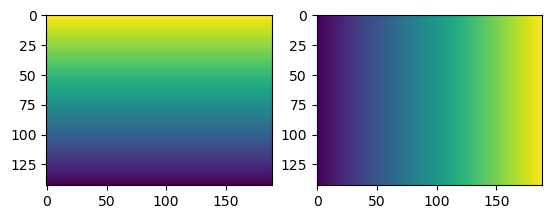

In [13]:
c = any_source['coords']
lat, lon = c[0], c[1]
plt.subplot(121)
plt.imshow(lat)
plt.subplot(122)
plt.imshow(lon)
# Time coordinate
print(any_source['dt'])

```landmask``` is the land-sea mask:

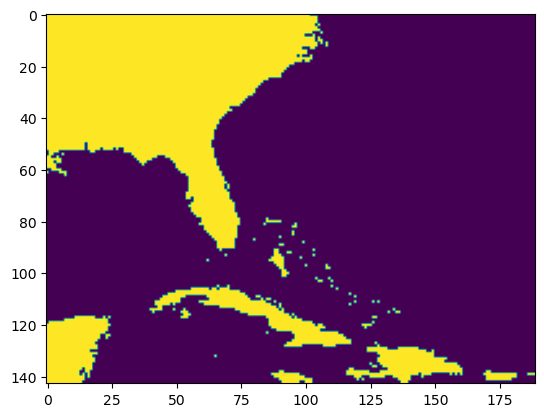

In [14]:
plt.imshow(any_source['landmask'])

## Context variables
Each source has its own set of context variables. All samples from a common source have the same context variables, but their values may change across samples.  
For example, the context for microwave observations includes the frequency (in GHz) and four values in km characterizing the IFOV.

In [15]:
any_source['context']  # freq, IFOV_nadir_along_track, IFOV_nadir_across_track, IFOV_edge_along_track, IFOV_edge_across_track

tensor([-1.0568, -0.6524, -0.8677, -0.7769, -0.6814], dtype=torch.float64)

## Values
Let's now look at the values (i.e. the observation themselves).

In [16]:
v = any_source['values']
v.shape

torch.Size([1, 143, 189])

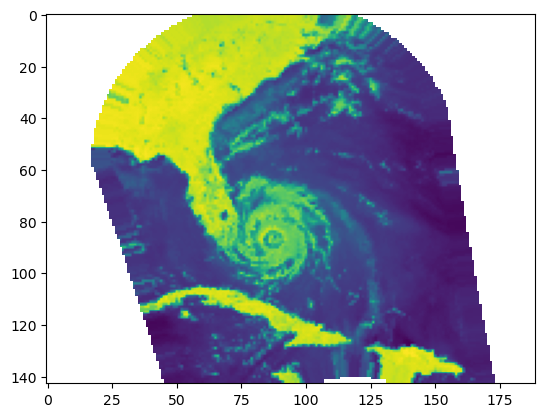

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=v.shape[0], squeeze=False)
for i in range(v.shape[0]):
    axes[0, i].imshow(v[i])